In [1]:
import os
import torch
import torchvision
import numpy as np
import pandas as pd
from PIL import Image
from torch import optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
import time
from model_utils import *
from pytorch_helpers import *

%matplotlib inline

# Explore and clean the data
In this section, we want to explore the data and prepare for image classification. 

In [2]:
# create a df from styles.csv neglecting lines with error
DATASET_PATH = '/mnt/fashion-dataset-1/fashion-dataset/'
styles = pd.read_csv(os.path.join(DATASET_PATH, "styles.csv"), error_bad_lines=False) 

b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

In [3]:
print(styles.head())

      id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

     year   usage                             productDisplayName  
0  2011.0  Casual               Turtle Check Men Navy Blue Shirt  
1  2012.0  Casual             Peter England Men Party Blue Jeans  
2  2016.0  Casual                       Titan Women Silver Watch  
3  2011.0  Casual  Manchester United Men Solid Black Track Pants  
4  2012.0  Casual                          Puma Men Grey T-shirt  


In [4]:
print(len(styles))

44424


In [5]:
# Get the list of names of images that are available
imgs_available = os.listdir(DATASET_PATH + '/images')
print(len(imgs_available))

44442


We want to check if each entry in styles.csv has a corresponding images listing. If not, we remove it from the dataframe.

In [6]:
# Check if each entry in styles.csv has a corresponding images listing. 
# If not, we remove it from the dataframe.
missing_img = []
for idx, line in styles.iterrows():
    if not os.path.exists(os.path.join(DATASET_PATH, 'images', str(line.id)+'.jpg')):
        print(os.path.join(DATASET_PATH, 'images', str(line.id)+'.jpg'))
        missing_img.append(idx)
        
styles.drop(styles.index[missing_img], inplace=True)

/mnt/fashion-dataset-1/fashion-dataset/images/39403.jpg
/mnt/fashion-dataset-1/fashion-dataset/images/39410.jpg
/mnt/fashion-dataset-1/fashion-dataset/images/39401.jpg
/mnt/fashion-dataset-1/fashion-dataset/images/39425.jpg
/mnt/fashion-dataset-1/fashion-dataset/images/12347.jpg


In [7]:
print(len(styles))

44419


## Getting the top articleTypes 

In [8]:
# Check how many unique article types we have
uniquie_article_types = styles['articleType'].unique()
print(len(uniquie_article_types))

142


There are 142 distinct articleTypes. In the next cell we are going to see what are the top 20 of them.

In [9]:
sorted_df = styles.groupby(['articleType']).size().sort_values(ascending=False)
top_classes = sorted_df.nlargest(20)
display(top_classes)

articleType
Tshirts                  7066
Shirts                   3215
Casual Shoes             2845
Watches                  2542
Sports Shoes             2036
Kurtas                   1844
Tops                     1762
Handbags                 1759
Heels                    1323
Sunglasses               1073
Wallets                   936
Flip Flops                914
Sandals                   897
Briefs                    849
Belts                     813
Backpacks                 724
Socks                     686
Formal Shoes              637
Perfume and Body Mist     613
Jeans                     608
dtype: int64

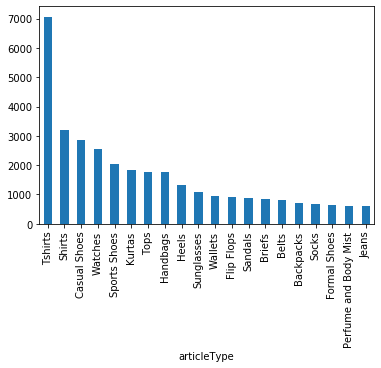

In [10]:
# plot the distribution of top 20 classes
top_classes.plot.bar()

# Transfer Learning / Fine tuning

### Create master train and test splits of the valid image data, with everything in even years used for the training set, and everything in an odd year used for the test split.
Before doing that, we should check if there are any entries with not valid articleType or year and remove them

In [11]:
styles.dropna(inplace=True, subset=['year','articleType'])
len(styles)

44418

In [12]:
training_data = styles[styles['year'].astype('int') % 2 == 0]
testing_data = styles[styles['year'].astype('int') % 2 == 1]

### Create sub-splits of the training data for pre-training and fine tuning 
We will do it as follows:
* the top 20 classes (see above) - about 3/4 of the data; and
* all other classes - about 1/4 of the data

In [13]:
top_classes_names = list(top_classes.index)

In [14]:
training_top20 = training_data[training_data.articleType.isin(top_classes_names)]
testing_top20 = testing_data[testing_data.articleType.isin(top_classes_names)]

### Find weights in order to handle the problem of imbalanced dataset
Reference: https://towardsdatascience.com/handling-imbalanced-datasets-in-deep-learning-f48407a0e758
Class balancing techniques play an important role when we actually care about the minority classes. In the figure above we can see the distribution of the training data which shows us that the dataset is imbalanced.

Weight balancing balances our data by altering the weight that each training example carries when computing the loss. Normally, each example and class in our loss function will carry equal weight i.e 1.0. But sometimes we might want certain classes or certain training examples to hold more weight if they are more important. That's what we do in the next step: we assign to each class i the following weight $w_i$:

\begin{equation}
w_i = \frac{total\_number\_of\_samples}{number\_of\_class\_samples}
\end{equation}

In [15]:
# Find weights 
total_number_of_samples = np.sum(top_classes.values)
weights = [total_number_of_samples/top_classes.values]

### Constructing datasets and dataloaders

In [16]:
# Create a mapping between article types and their ids
cat_list = sorted_df.index
cat2num = {cat:i for i, cat in enumerate(cat_list)}
num2cat = {i:cat for i, cat in enumerate(cat_list)}

In [17]:
# Create data transform
transform = torchvision.transforms.Compose([
                torchvision.transforms.Resize((224, 224)),
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])

In [18]:
# number of subprocesses to use for data loading
num_workers = 8
# how many samples per batch to load
batch_size = 16
# percentage of training set to use as validation
valid_size = 0.2

In [19]:
# Construct datasets
top20_data = FIDataset(os.path.join(DATASET_PATH, 'images'), training_top20, transform, cat2num)
# others_data = FIDataset(os.path.join(DATASET_PATH, 'images'), training_others, transform, cat2num)

test_top20 = FIDataset(os.path.join(DATASET_PATH, 'images'), testing_top20, transform, cat2num)

In [20]:
# split the training data for 'top 20' classes into train and validation datasets
top20_train_sampler, top20_valid_sampler = split_train_valid(top20_data, valid_size)

# prepare data loaders
top20_train_loader = DataLoader(top20_data, batch_size=batch_size, 
                                sampler=top20_train_sampler, num_workers=num_workers)
top20_valid_loader = DataLoader(top20_data, batch_size=batch_size, 
                                sampler=top20_valid_sampler, num_workers=num_workers)
top20_test_loader = DataLoader(test_top20, batch_size=batch_size, num_workers=num_workers)

### Visualizing sample data from the training dataset

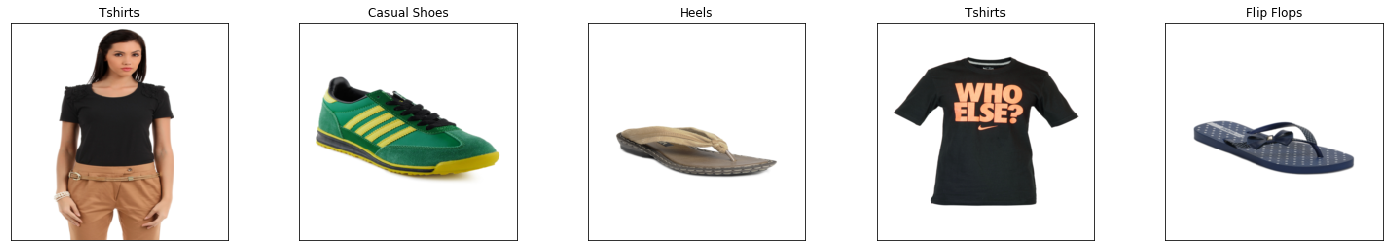

In [21]:
# Plot sample data from the training dataset of top 20 classes
plot_sample_data(top20_train_loader, 5, num2cat)

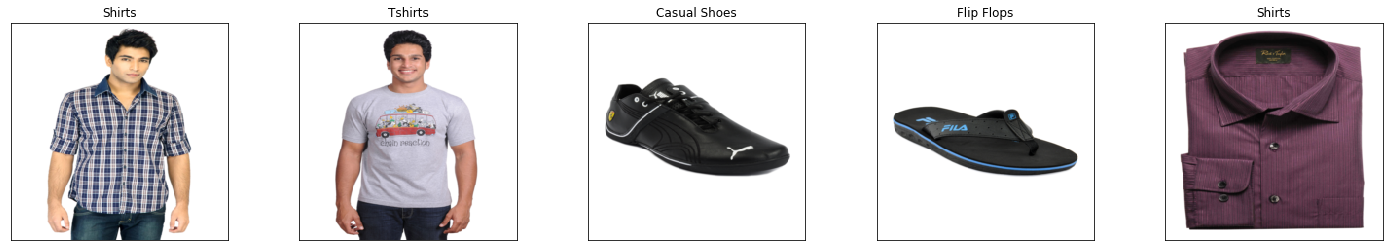

In [22]:
# Plot sample data from the training dataset of the remaining classes
plot_sample_data(top20_test_loader, 5, num2cat)

### Train a classifier network by initializing from a pretrained network (we choose ResNet50 trained on ImageNet) and retraining the weights of the whole network.

In [23]:
# Check if CUDA is available
use_cuda = torch.cuda.is_available()

# Specify model architecture 
model_top20 = models.resnet50(pretrained=True)

# To reshape the network, we reinitialize the classifier’s linear layer
n_inp = model_top20.fc.in_features
model_top20.fc = nn.Linear(n_inp, len(top_classes_names))

if use_cuda:
    model_top20 = model_top20.cuda()

In [24]:
print(model_top20.fc)

Linear(in_features=2048, out_features=20, bias=True)


In [25]:
# Convert weights vector to a tensor
weights = torch.tensor(weights,  dtype=torch.float)

if use_cuda:
    weights = weights.cuda()

# Specify a loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=weights)

optimizer = optim.SGD(model_top20.parameters(), lr=0.001)

In [47]:
n_epochs = 20

# train the model
model_top20, train_loss_history_top20, valid_loss_history_top20 = train(n_epochs, top20_train_loader, 
                                                      top20_valid_loader, model_top20, optimizer, 
                                                      criterion, use_cuda, 'model_top20.pt')

Epoch: 1/20 	Training Loss: 1.282063 	Validation Loss: 0.465129
Validation loss decreased (inf --> 0.465129).  Saving model ...
Epoch: 2/20 	Training Loss: 0.432186 	Validation Loss: 0.268926
Validation loss decreased (0.465129 --> 0.268926).  Saving model ...
Epoch: 3/20 	Training Loss: 0.288576 	Validation Loss: 0.224760
Validation loss decreased (0.268926 --> 0.224760).  Saving model ...
Epoch: 4/20 	Training Loss: 0.228203 	Validation Loss: 0.190162
Validation loss decreased (0.224760 --> 0.190162).  Saving model ...
Epoch: 5/20 	Training Loss: 0.186361 	Validation Loss: 0.180894
Validation loss decreased (0.190162 --> 0.180894).  Saving model ...
Epoch: 6/20 	Training Loss: 0.156727 	Validation Loss: 0.165075
Validation loss decreased (0.180894 --> 0.165075).  Saving model ...
Epoch: 7/20 	Training Loss: 0.136485 	Validation Loss: 0.160109
Validation loss decreased (0.165075 --> 0.160109).  Saving model ...
Epoch: 8/20 	Training Loss: 0.121992 	Validation Loss: 0.153523
Validation

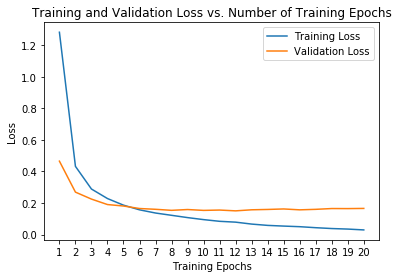

In [49]:
plot_training_and_valid_loss(train_loss_history_top20, valid_loss_history_top20, n_epochs)

### Testing results

In [26]:
# Load the model that got the best validation accuracy
model_top20.load_state_dict(torch.load('model_top20.pt'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

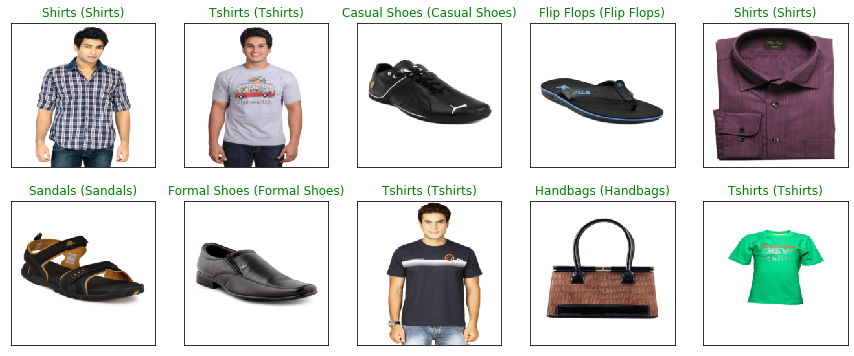

In [27]:
plot_sample_data_model(top20_test_loader, 10, model_top20, num2cat, use_cuda=True)

In [28]:
top20_cat_lookup = {i:j for i, j in num2cat.items() if j in top_classes_names}
test(top20_test_loader, model_top20, criterion, cat_lookup=top20_cat_lookup, use_cuda=True)

Test Loss: 1.080714


Printing accuracy for each class
Test accuracy of Tshirts: 
Top-1 accuracy: 88% (3822/4316) 
Top-5 accuracy: 99% (4312/4316)
Test accuracy of Shirts: 
Top-1 accuracy: 98% (2060/2087) 
Top-5 accuracy: 100% (2087/2087)
Test accuracy of Casual Shoes: 
Top-1 accuracy: 78% (1014/1295) 
Top-5 accuracy: 99% (1291/1295)
Test accuracy of Watches: 
Top-1 accuracy: 100% (60/60) 
Top-5 accuracy: 100% (60/60)
Test accuracy of Sports Shoes: 
Top-1 accuracy: 86% (1000/1155) 
Top-5 accuracy: 99% (1150/1155)
Test accuracy of Kurtas: 
Top-1 accuracy: 97% (689/704) 
Top-5 accuracy: 100% (704/704)
Test accuracy of  Tops: 
Top-1 accuracy: 84% (597/703) 
Top-5 accuracy: 100% (703/703)
Test accuracy of Handbags: 
Top-1 accuracy: 96% (723/753) 
Top-5 accuracy: 99% (752/753)
Test accuracy of Heels: 
Top-1 accuracy: 93% (515/548) 
Top-5 accuracy: 99% (546/548)
Test accuracy of Sunglasses: 
Top-1 accuracy: 100% (31/31) 
Top-5 accuracy: 100% (31/31)
Test accuracy of Wallets: 
Top-1 accuracy:

# Fine tuning the model

### Constructing datasets and dataloaders

In [29]:
# Data augmentation
transform_augment = torchvision.transforms.Compose([
                torchvision.transforms.Resize((224, 224)),
                torchvision.transforms.RandomHorizontalFlip(),
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])

In [30]:
# Construct datasets
test_data = FIDataset(os.path.join(DATASET_PATH, 'images'), testing_data, transform, cat2num)
training_dataset = FIDataset(os.path.join(DATASET_PATH, 'images'), training_data, transform_augment, cat2num)
valid_dataset = FIDataset(os.path.join(DATASET_PATH, 'images'), training_data, transform, cat2num)

# split the training data into train and validation datasets
train_sampler, valid_sampler = split_train_valid(training_dataset, valid_size)

# prepare data loaders
train_loader = DataLoader(training_dataset, batch_size=batch_size, 
                                sampler=train_sampler, num_workers=num_workers)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, 
                                sampler=valid_sampler, num_workers=num_workers)

test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

### Visualizing sample data from the training dataset

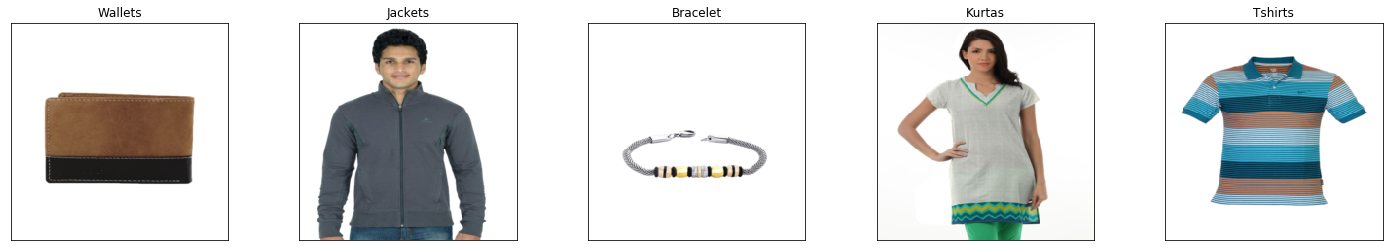

In [31]:
# Plot sample data from the training dataset of top 20 classes
plot_sample_data(train_loader, 5, num2cat)

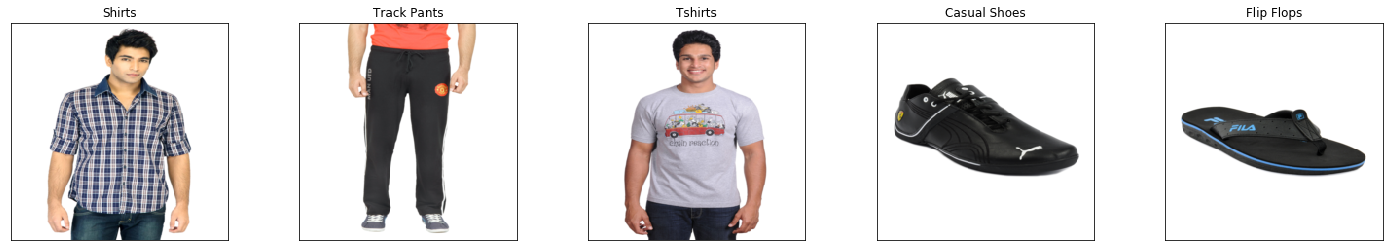

In [32]:
# Plot sample data from the training dataset of top 20 classes
plot_sample_data(test_loader, 5, num2cat)

### Fine tuning

Replace the 20-class FC layer with a 142-class output layer. Freeze the initial 5 layers of the pretrained model (model_top20) and train just the remaining layers again. The top layers would then be customized to the new data set. Since the new data set contains 122 new classes with low similarity, it is a good idea to retrain and customize the higher layers according to the new dataset. The initial layers are kept pretrained and the weights for those layers are frozen.

In [43]:
model_142 = model_top20

# Freeze the first 5 layers of the model
layers_to_freeze=5
layer_count=0

print('Layers to freeze: \n')
for child in model_142.children():
    layer_count+=1
    if layer_count <= layers_to_freeze:
        print(child)
        for param in child.parameters():
            param.requires_grad = False

Layers to freeze: 

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace)
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affi

In [44]:
# To reshape the network, we reinitialize the classifier’s linear layer
n_inp = model_142.fc.in_features
model_142.fc = nn.Linear(n_inp, len(uniquie_article_types))

if use_cuda:
    model_142 = model_142.cuda()

In [45]:
# Define the weights for all the 142 classes as before
total_number_of_samples = np.sum(sorted_df.values)
weights = [total_number_of_samples/sorted_df.values]

In [46]:
# Convert weights vector to a tensor
weights = torch.tensor(weights,  dtype=torch.float)

if use_cuda:
    weights = weights.cuda()

# Specify a loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=weights)

optimizer = optim.SGD(model_142.parameters(), lr=0.001)

### Training the model

In [47]:
n_epochs = 20

# train the model
model_142, train_loss_history_142, valid_loss_history_142 = train(n_epochs, train_loader, 
                                                      valid_loader, model_142, optimizer, 
                                                      criterion, use_cuda, 'model_142_augment2.pt')

Epoch: 1/20 	Training Loss: 2.466297 	Validation Loss: 1.122939
Validation loss decreased (inf --> 1.122939).  Saving model ...
Epoch: 2/20 	Training Loss: 1.190912 	Validation Loss: 0.845237
Validation loss decreased (1.122939 --> 0.845237).  Saving model ...
Epoch: 3/20 	Training Loss: 0.879575 	Validation Loss: 0.695977
Validation loss decreased (0.845237 --> 0.695977).  Saving model ...
Epoch: 4/20 	Training Loss: 0.722751 	Validation Loss: 0.647597
Validation loss decreased (0.695977 --> 0.647597).  Saving model ...
Epoch: 5/20 	Training Loss: 0.595503 	Validation Loss: 0.550076
Validation loss decreased (0.647597 --> 0.550076).  Saving model ...
Epoch: 6/20 	Training Loss: 0.498029 	Validation Loss: 0.545056
Validation loss decreased (0.550076 --> 0.545056).  Saving model ...
Epoch: 7/20 	Training Loss: 0.430632 	Validation Loss: 0.522554
Validation loss decreased (0.545056 --> 0.522554).  Saving model ...
Epoch: 8/20 	Training Loss: 0.367149 	Validation Loss: 0.521726
Validation

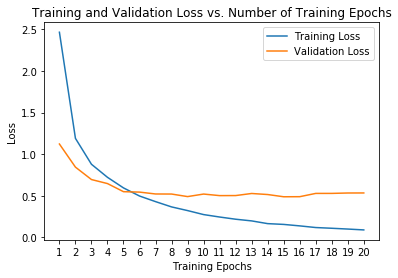

In [48]:
plot_training_and_valid_loss(train_loss_history_142, valid_loss_history_142, n_epochs)

### Testing results

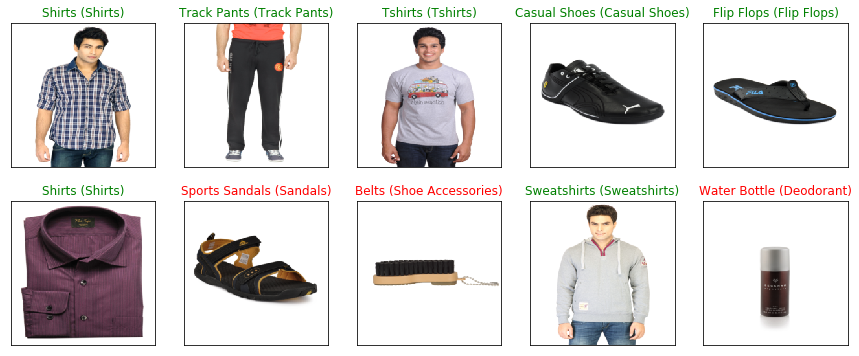

In [49]:
plot_sample_data_model(test_loader, 10, model_142, num2cat, use_cuda=True)

In [50]:
# Load the model that got the best validation accuracy
model_142.load_state_dict(torch.load('model_142_augment2.pt'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [51]:
test(test_loader, model_142, criterion, cat_lookup=num2cat, use_cuda=True)

Test Loss: 4.917461


Printing accuracy for each class
Test accuracy of Tshirts: 
Top-1 accuracy: 88% (3815/4316) 
Top-5 accuracy: 98% (4255/4316)
Test accuracy of Shirts: 
Top-1 accuracy: 96% (2007/2087) 
Top-5 accuracy: 99% (2076/2087)
Test accuracy of Casual Shoes: 
Top-1 accuracy: 80% (1045/1295) 
Top-5 accuracy: 99% (1285/1295)
Test accuracy of Watches: 
Top-1 accuracy: 93% (56/60) 
Top-5 accuracy: 100% (60/60)
Test accuracy of Sports Shoes: 
Top-1 accuracy: 85% (990/1155) 
Top-5 accuracy: 99% (1146/1155)
Test accuracy of Kurtas: 
Top-1 accuracy: 90% (635/704) 
Top-5 accuracy: 99% (698/704)
Test accuracy of  Tops: 
Top-1 accuracy: 65% (461/703) 
Top-5 accuracy: 97% (685/703)
Test accuracy of Handbags: 
Top-1 accuracy: 88% (669/753) 
Top-5 accuracy: 97% (736/753)
Test accuracy of Heels: 
Top-1 accuracy: 71% (391/548) 
Top-5 accuracy: 99% (544/548)
Test accuracy of Sunglasses: 
Top-1 accuracy: 100% (31/31) 
Top-5 accuracy: 100% (31/31)
Test accuracy of Wallets: 
Top-1 accuracy: 94% 